# install

In [1]:
!pip install ultralytics opencv-python numpy matplotlib tqdm ipython

# Imports and Setup

In [2]:
# %% Imports and Setup
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time # 引入 time 模組
from collections import defaultdict

import torch
# torch.classes.__path__ = [] # Potentially not needed in Jupyter, but kept if specific env issues arise
import numpy as np
from ultralytics import YOLO
from tqdm.notebook import tqdm # For progress bar in Jupyter

import matplotlib.pyplot as plt
from IPython.display import display, Video, clear_output, HTML # For displaying video and richer output

# --- Configuration ---
MODEL_PATH = 'yolov8n.pt'  # You can choose different YOLOv8 models
TARGET_CLASSES = [0, 2] # COCO dataset: 0: person, 2: car
TARGET_CLASS_NAMES = {0: 'Person', 2: 'Car'} # For displaying class names
CONFIDENCE_THRESHOLD = 0.3
TRACKER_CONFIG = 'bytetrack.yaml' # Make sure this file exists or Ultralytics can fetch it

# --- Bounding Box Drawing Parameters ---
BOX_COLOR = (0, 255, 0) # BGR format green
BOX_THICKNESS = 2
TEXT_COLOR = (0, 255, 0) # Green, but will be changed to white on green background
TEXT_FONT_SCALE = 0.5
TEXT_THICKNESS = 1
TEXT_FONT = cv2.FONT_HERSHEY_SIMPLEX

# --- Jupyter Specific Output Control ---
MAX_REPRESENTATIVE_FRAMES_DISPLAY = 12 # Max representative frames to show at once
FRAMES_PER_ROW_REPRESENTATIVE = 4
MAX_SELECTED_TRACK_FRAMES_DISPLAY = 20 # Max frames to show for a selected track
FRAMES_PER_ROW_SELECTED = 5

# %% Helper Functions

# No caching decorator needed for simple script, model loaded once.
# If you were calling load_model multiple times with same path, functools.lru_cache could be used.
def load_model(model_path):
    """Load YOLO model"""
    try:
        model = YOLO(model_path)
        print(f"Model '{model_path}' loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def draw_bounding_box(frame, box, track_id, class_name):
    """Draw a single bounding box and label on the given frame."""
    img_with_box = frame.copy() # Create a copy to avoid modifying the original frame
    x1, y1, x2, y2 = map(int, box) # Ensure coordinates are integers
    label = f'ID:{track_id} {class_name}'

    # Draw bounding box
    cv2.rectangle(img_with_box, (x1, y1), (x2, y2), BOX_COLOR, BOX_THICKNESS)

    # Draw label background
    (w, h), _ = cv2.getTextSize(label, TEXT_FONT, TEXT_FONT_SCALE, TEXT_THICKNESS)
    label_y = y1 - 10 if y1 - 10 > h else y1 + h + 10 # Prevent label from going off screen top
    cv2.rectangle(img_with_box, (x1, label_y - h - 5), (x1 + w, label_y), BOX_COLOR, -1) # -1 for filled

    # Draw label text (white on green background for better visibility)
    cv2.putText(img_with_box, label, (x1, label_y - 3), TEXT_FONT, TEXT_FONT_SCALE, (255, 255, 255), TEXT_THICKNESS, lineType=cv2.LINE_AA)
    
    return img_with_box

def process_video(video_path, model):
    """
    Process video, detect and track objects, store frames and corresponding bounding box info.

    Returns:
        tuple: (tracked_object_frames, representative_frames)
               tracked_object_frames: dict[int, list[tuple(np.ndarray, tuple)]]
                   - Stores list of (original_frame, box_coordinates) for each track_id
               representative_frames: dict[int, tuple(np.ndarray, str, tuple)]
                   - Stores (original_frame, class_name, box_coordinates) for each track_id
    """
    tracked_object_frames = defaultdict(list)
    representative_frames = {}
    # object_classes = {} # Not explicitly used later for now, but could be useful

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video file.")
            return {}, {}

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Initialize tqdm progress bar
        pbar = tqdm(total=total_frames, desc="Processing video")
        frame_count = 0
        start_time = time.time()

        while True:
            success, frame = cap.read()
            if not success:
                break

            frame_count += 1
            current_time = time.time()
            elapsed_time = current_time - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            
            pbar.set_postfix_str(f"FPS: {fps:.2f}")

            # Use YOLO model for tracking
            results = model.track(
                source=frame,
                tracker=TRACKER_CONFIG,
                classes=TARGET_CLASSES,
                conf=CONFIDENCE_THRESHOLD,
                persist=True, # Keep tracks between frames
                verbose=False # Suppress Ultralytics output for cleaner console
            )

            if results and results[0].boxes is not None and results[0].boxes.id is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy() # Keep as float for potential precision
                track_ids = results[0].boxes.id.cpu().numpy().astype(int)
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

                for box, track_id, cls_id in zip(boxes, track_ids, class_ids):
                    # Store the original frame and box coordinates for this object
                    tracked_object_frames[track_id].append((frame.copy(), tuple(box)))

                    # If this is the first time seeing this track_id, store its representative frame info
                    if track_id not in representative_frames:
                        class_name = TARGET_CLASS_NAMES.get(cls_id, f'Class {cls_id}')
                        representative_frames[track_id] = (frame.copy(), class_name, tuple(box))
                        # object_classes[track_id] = cls_id

            pbar.update(1)

        cap.release()
        pbar.close()
        print("Video processing complete!")
        
        end_time = time.time()
        total_processing_time = end_time - start_time
        avg_fps = total_frames / total_processing_time if total_processing_time > 0 else 0
        print(f"Total frames: {total_frames}, Processed in: {total_processing_time:.2f}s, Average FPS: {avg_fps:.2f}")


        return tracked_object_frames, representative_frames

    except Exception as e:
        print(f"An error occurred during video processing: {e}")
        if 'cap' in locals() and cap.isOpened():
            cap.release()
        if 'pbar' in locals():
            pbar.close()
        return {}, {}

# Execution

In [3]:
# %% --- Main Script Execution ---

# --- 1. Define Video Path ---
# << IMPORTANT >>: Replace this with the actual path to your video file
VIDEO_FILE_PATH = "video/3105211-sd_640_360_30fps.mp4" # e.g., "test_video.mp4" or "/path/to/your/video.mov"

if not os.path.exists(VIDEO_FILE_PATH):
    print(f"ERROR: Video file not found at '{VIDEO_FILE_PATH}'. Please set the correct path.")
    # You might want to stop execution here if the file isn't found
    # For Jupyter, an error message is usually enough, or raise FileNotFoundError
else:
    print(f"Attempting to process video: {VIDEO_FILE_PATH}")
    # Display the video in Jupyter (optional)
    # display(Video(VIDEO_FILE_PATH, embed=True, width=400)) # Smaller width for display

    # --- 2. Load Model ---
    yolo_model = load_model(MODEL_PATH)

    tracked_data = None
    representative_frames_data = None

    if yolo_model:
        # --- 3. Process Video ---
        # This is where the main processing happens
        print("\nStarting video processing...")
        tracked_data, representative_frames_data = process_video(VIDEO_FILE_PATH, yolo_model)
    else:
        print("Model could not be loaded. Aborting video processing.")


Attempting to process video: video/3105211-sd_640_360_30fps.mp4
Model 'yolov8n.pt' loaded successfully.

Starting video processing...


Processing video:   0%|          | 0/280 [00:00<?, ?it/s]

Video processing complete!
Total frames: 280, Processed in: 17.25s, Average FPS: 16.23



--- Tracked Object Results ---
Detected and tracked 52 unique objects (Persons or Cars).

--- Representative Frame for Each Object (with Bounding Box) ---
Displaying first 12 out of 52 detected objects.


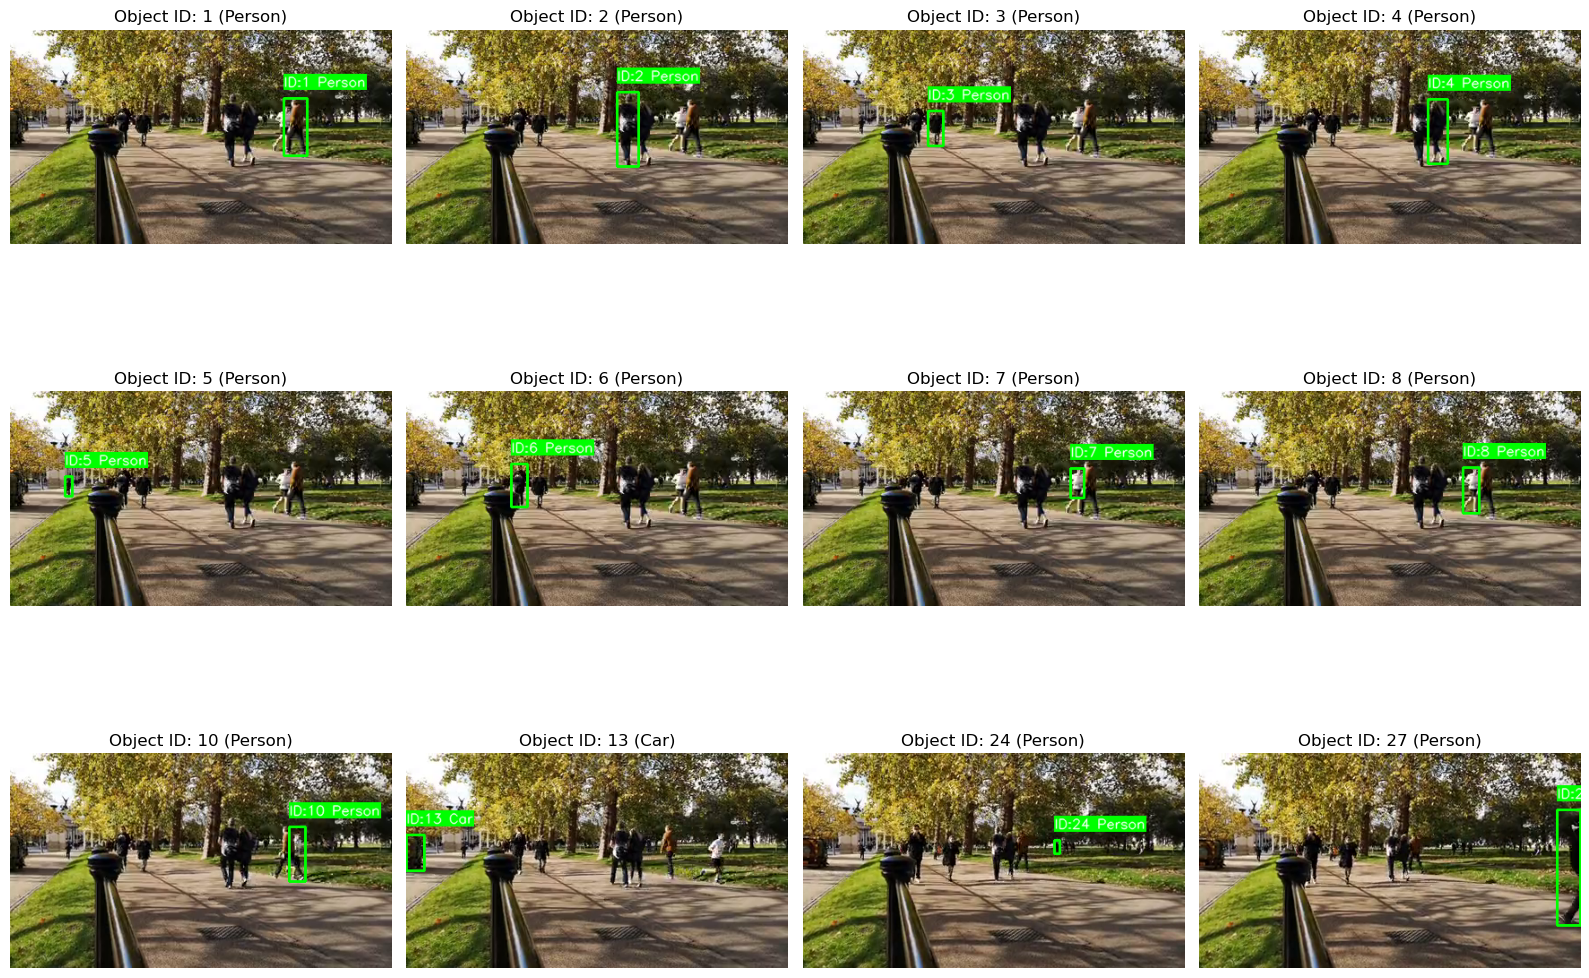

In [4]:

# --- 4. Display Results ---
if representative_frames_data:
    print(f"\n--- Tracked Object Results ---")
    print(f"Detected and tracked {len(representative_frames_data)} unique objects (Persons or Cars).")

    print("\n--- Representative Frame for Each Object (with Bounding Box) ---")
    
    track_ids_list = list(representative_frames_data.keys())
    num_objects = len(track_ids_list)
    
    if num_objects == 0:
        print("No objects detected or tracked.")
    else:
        # Limit the number of representative frames displayed directly in the notebook
        num_to_display = min(num_objects, MAX_REPRESENTATIVE_FRAMES_DISPLAY)
        if num_objects > MAX_REPRESENTATIVE_FRAMES_DISPLAY:
             print(f"Displaying first {MAX_REPRESENTATIVE_FRAMES_DISPLAY} out of {num_objects} detected objects.")
        
        cols = FRAMES_PER_ROW_REPRESENTATIVE
        rows = (num_to_display + cols - 1) // cols # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        axes = axes.flatten() # Flatten to 1D array for easy indexing

        for i in range(num_to_display):
            track_id = track_ids_list[i]
            rep_frame_bgr, class_name, box = representative_frames_data[track_id]
            
            frame_with_box = draw_bounding_box(rep_frame_bgr, box, track_id, class_name)
            rep_frame_rgb = cv2.cvtColor(frame_with_box, cv2.COLOR_BGR2RGB)
            
            ax = axes[i]
            ax.imshow(rep_frame_rgb)
            ax.set_title(f"Object ID: {track_id} ({class_name})")
            ax.axis('off')
        
        # Hide any unused subplots
        for j in range(num_to_display, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()




--- All Frames for a Selected Object ---

Displaying frames for Object ID: 1 (Person) - Total 9 frames.


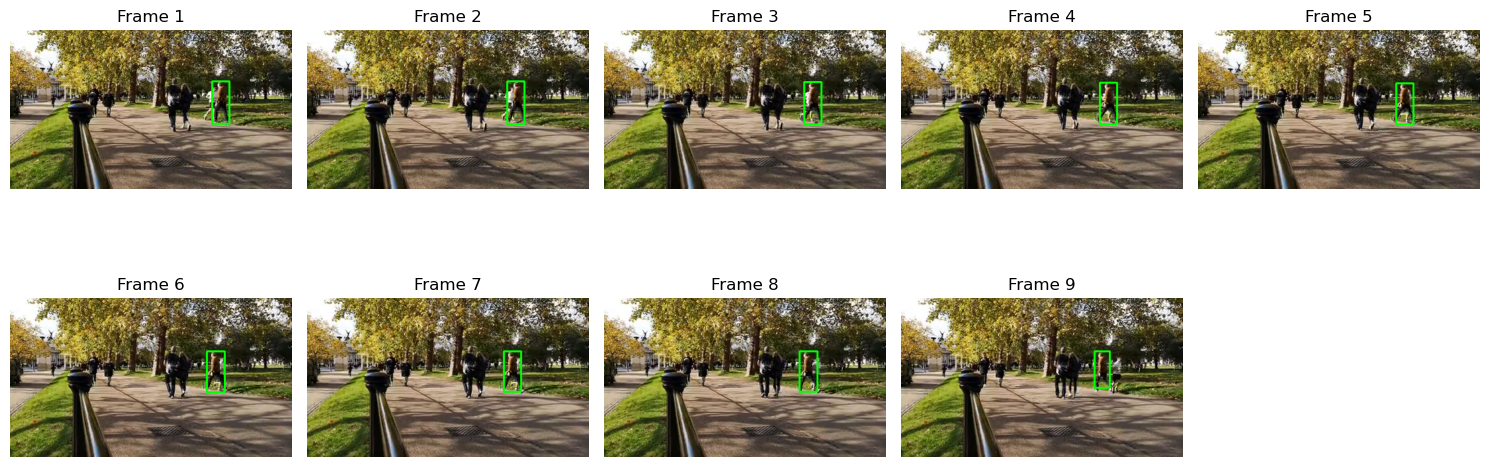


---


In [5]:
# --- 5. Display All Frames for a CHOSEN Object ---
print("\n--- All Frames for a Selected Object ---")

# <<< IMPORTANT >>>: Set this to the ID you want to inspect from the output above
# If no specific ID, it will try the first one if available.
CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES = 1 

if not CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES and track_ids_list:
    CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES = track_ids_list[0] # Default to the first track ID
    print(f"No specific track ID chosen. Displaying frames for the first tracked object: ID {CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES}")
elif not track_ids_list:
     print("No objects were tracked, so no specific frames to display.")
     CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES = None


if CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES is not None and tracked_data:
    selected_id = CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES
    if selected_id in tracked_data:
        frames_data_to_show = tracked_data[selected_id]
        
        _rep_frame, class_name_selected, _rep_box = representative_frames_data.get(selected_id, (None, "Unknown", None))

        print(f"\nDisplaying frames for Object ID: {selected_id} ({class_name_selected}) - Total {len(frames_data_to_show)} frames.")

        num_frames_selected = len(frames_data_to_show)
        num_to_display_selected = min(num_frames_selected, MAX_SELECTED_TRACK_FRAMES_DISPLAY)

        if num_frames_selected > MAX_SELECTED_TRACK_FRAMES_DISPLAY:
            print(f"This object appeared in {num_frames_selected} frames. Displaying the first {MAX_SELECTED_TRACK_FRAMES_DISPLAY}.")
        
        if num_to_display_selected > 0:
            cols_sel = FRAMES_PER_ROW_SELECTED
            rows_sel = (num_to_display_selected + cols_sel - 1) // cols_sel
            
            fig_sel, axes_sel = plt.subplots(rows_sel, cols_sel, figsize=(cols_sel * 3, rows_sel * 3))
            if rows_sel == 1 and cols_sel == 1: # Handle single plot case
                 axes_sel = np.array([axes_sel])
            axes_sel = axes_sel.flatten()

            for idx, frame_data in enumerate(frames_data_to_show[:num_to_display_selected]):
                frame_bgr, box = frame_data
                # For simplicity, just draw a rectangle. For full label use draw_bounding_box
                frame_to_display = frame_bgr.copy()
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame_to_display, (x1, y1), (x2, y2), BOX_COLOR, BOX_THICKNESS)
                
                # If you want the full label on each frame:
                # frame_to_display = draw_bounding_box(frame_bgr, box, selected_id, class_name_selected)


                frame_rgb = cv2.cvtColor(frame_to_display, cv2.COLOR_BGR2RGB)
                
                ax = axes_sel[idx]
                ax.imshow(frame_rgb)
                ax.set_title(f"Frame {idx+1}")
                ax.axis('off')
            
            for j in range(num_to_display_selected, len(axes_sel)):
                fig_sel.delaxes(axes_sel[j])
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No frames to display for object ID {selected_id}")

    else:
        print(f"Could not find data for Track ID {selected_id}.")
elif CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES is not None:
     print(f"Track ID {CHOOSE_TRACK_ID_TO_VIEW_ALL_FRAMES} was specified, but no tracking data is available (tracked_data is empty or None).")


# --- Footer ---
print("\n---")
display(HTML("<em>Powered by Ultralytics YOLOv8 and Jupyter</em>"))